In [1]:
%load_ext autoreload
%autoreload 2
import sys
# do this to be able to import the custom python scripts
sys.path.insert(1, "../../../python_scripts")
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import dedupe 

import dm_diagnostics as dmd
import dm_utils
import dm_plots
import dm_file_checker
from sklearn.metrics import confusion_matrix, accuracy_score

import json

## Get Appropriate Filepaths

In [2]:
saved_files_path = "../../../saved_files"
task_name = os.path.basename(os.getcwd())
dataset_name = task_name.split("-")[1]
    
# files to be read in
unlabeled_data_filepath = dm_file_checker.get_proper_unlabeled_data_filepath(task_name, saved_files_path)
settings_filepath =  dm_file_checker.get_filepath(task_name, "model_settings", saved_files_path)
labeled_data_filepath = dm_file_checker.get_filepath(task_name, "labeled_data", saved_files_path)
blocks_filepath = dm_file_checker.get_filepath(task_name, "blocks", saved_files_path)

# files to be written out as output
model_weights_filepath = dm_file_checker.get_filepath(task_name, "model_weights", saved_files_path)
mapped_records_filepath =  dm_file_checker.get_filepath(task_name, "mapped_records", saved_files_path)
labeled_pair_ids_filepath =  dm_file_checker.get_filepath(task_name, "labeled_pair_ids", saved_files_path)
cluster_canonical_filepath =  dm_file_checker.get_filepath(task_name, "cluster_canonical", saved_files_path)

numeric_fields = dm_file_checker.get_dataset_info(task_name, "numeric_fields", saved_files_path)
print("Numeric fields are {}".format(numeric_fields))

Numeric fields are []


## Setup: Reading in Unlabeled Data, Labeled Data, and Trained Model

In [3]:
# reading in unlabeled_data
unlabeled_data = dm_utils.read_unlabeled_data_json(unlabeled_data_filepath, numeric_fields = numeric_fields)

# reading in trained model
with open(settings_filepath, 'rb') as f:
    deduper = dedupe.StaticDedupe(f)

# reading in labeled data
with open(labeled_data_filepath, "r") as json_file:
    labeled_data = json.load(json_file)

converting 190 empty string values of column date_of_birth to None
converting 156 empty string values of column given_name to None
converting 79 empty string values of column surname to None
converting 245 empty string values of column street_number to None
converting 154 empty string values of column address_1 to None
converting 693 empty string values of column address_2 to None
converting 85 empty string values of column suburb to None
converting 0 empty string values of column postcode to None
converting 85 empty string values of column state to None
converting 0 empty string values of column soc_sec_id to None


INFO:dedupe.api:(SimplePredicate: (sameThreeCharStartPredicate, soc_sec_id), (SimplePredicate: (dayPredicate, date_of_birth), SimplePredicate: (hundredIntegersOddPredicate, postcode)), (SimplePredicate: (fingerprint, address_2), SimplePredicate: (fingerprint, given_name)), (SimplePredicate: (commonThreeTokens, address_1), SimplePredicate: (fingerprint, given_name)))


## Finding Record IDs of Labeled Data

In [4]:
labeled_pairs_df = dm_utils.find_ids_of_labeled_data(labeled_data, unlabeled_data)
labeled_pairs_df.to_csv(labeled_pair_ids_filepath, index = False, encoding = "utf-8")
labeled_pairs_df

  0%|          | 0/60 [00:00<?, ?it/s]

Finding ids for distinct pairs


 44%|████▍     | 29/66 [00:00<00:00, 276.09it/s]

Finding ids for match pairs


100%|██████████| 66/66 [00:00<00:00, 242.79it/s]


,record id 1,record id 2,label
0,febrl3-rec-1953-dup-3,febrl3-rec-1260-dup-0,distinct
1,febrl3-rec-1623-dup-2,febrl3-rec-669-dup-2,distinct
2,febrl3-rec-278-dup-1,febrl3-rec-1779-dup-0,distinct
3,febrl3-rec-1390-org,febrl3-rec-1029-dup-2,distinct
4,febrl3-rec-546-dup-3,febrl3-rec-1875-org,distinct
...,...,...,...
121,febrl3-rec-397-dup-1,febrl3-rec-397-dup-0,match
122,febrl3-rec-511-dup-2,febrl3-rec-511-dup-4,match
123,febrl3-rec-1953-dup-0,febrl3-rec-1953-dup-2,match
124,febrl3-rec-772-dup-1,febrl3-rec-772-dup-2,match


## Predicates for Indexing/Blocking

In [5]:
deduper.predicates

(SimplePredicate: (sameThreeCharStartPredicate, soc_sec_id),
 (SimplePredicate: (dayPredicate, date_of_birth),
  SimplePredicate: (hundredIntegersOddPredicate, postcode)),
 (SimplePredicate: (fingerprint, address_2),
  SimplePredicate: (fingerprint, given_name)),
 (SimplePredicate: (commonThreeTokens, address_1),
  SimplePredicate: (fingerprint, given_name)))

## Model Weights

In [6]:
# checking model weights
model_weights = dm_utils.get_model_weights(deduper)
model_weights.to_csv(model_weights_filepath, index = False, encoding = "utf-8")
model_weights

,variable,logistic_reg_weight
0,(postcode: ShortString),-4.044692
1,(soc_sec_id: ShortString),-3.786045
2,(address_1: String),-3.398163
3,(given_name: String),-2.999825
4,(street_number: ShortString),-2.274838
5,(suburb: String),-2.221105
6,(surname: String),-1.706562
7,(state: ShortString),-1.347700
8,(days: Derived),-0.088926
9,(seconds: Dummy),0.010516


## Thresholding
- Includes diagnostic plots to justify and explain the threshold

In [7]:
%%time
# Find the threshold that will maximize a weighted average of our
# precision and recall.  When we set the recall weight to 2, we are
# saying we care twice as much about recall as we do precision.
#
# If we had more data, we would not pass in all the blocked data into
# this function but a representative sample.

blocked_data = dm_utils.read_deduper_blocks(unlabeled_data, blocks_filepath)
probs, threshold = dm_utils.get_deduper_probs_and_threshold(deduper, unlabeled_data, 
                                                            blocked_data = blocked_data, recall_weight=1)

Maximum expected recall and precision
recall: 99.88%
precision: 99.89%
With threshold: 50.76%
CPU times: user 532 ms, sys: 71.3 ms, total: 603 ms
Wall time: 17.3 s


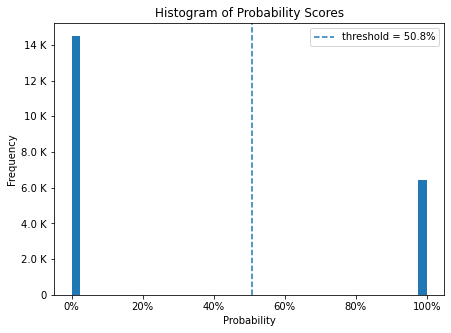

In [8]:
dm_plots.plot_prob_histogram(probs,threshold)

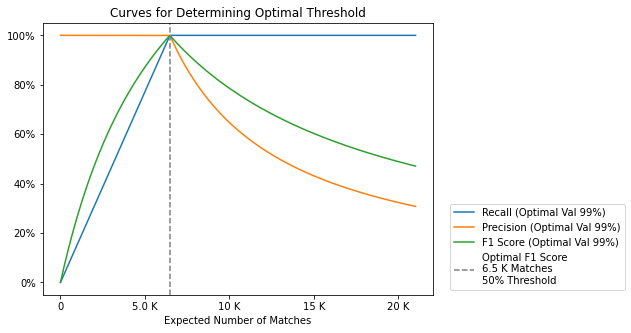

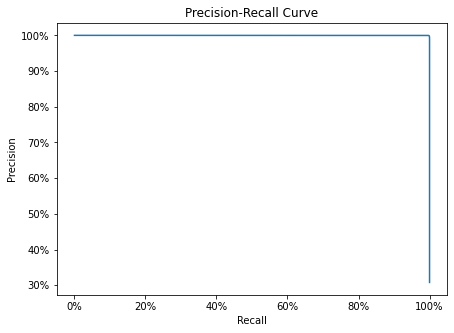

In [9]:
dm_plots.plot_threshold_finder_curves(probs,threshold,recall_weight = 1)

## Clustering and Canonicalization

In [10]:
%%time
blocked_data = dm_utils.read_deduper_blocks(unlabeled_data, blocks_filepath)
#blocked_data = None
mapped_records_df, canonicals_df = dm_utils.map_cluster_ids(deduper, unlabeled_data, threshold, 
                                                            blocked_data = blocked_data, numeric_fields = numeric_fields,
                                                           cluster_id_tag = dataset_name)

mapped_records_df.to_csv(mapped_records_filepath, index = False, encoding = "utf-8")
canonicals_df.to_csv(cluster_canonical_filepath, index = False, encoding = "utf-8")

1it [00:00,  7.20it/s]

Mapping cluster ids...


1170it [00:01, 1053.91it/s]
100%|██████████| 864/864 [00:00<00:00, 189305.68it/s]


Mapping solo record ids...
CPU times: user 1.64 s, sys: 87.2 ms, total: 1.73 s
Wall time: 15.8 s


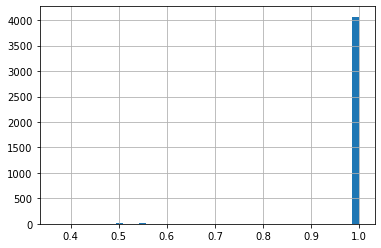

In [11]:
mapped_records_df["confidence score"].hist(bins = 40)
plt.show()

In [12]:
canonicals_df.head()

,date_of_birth,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,soc_sec_id,cluster id
0,1963/05/03,chloe,wasley,148,mclachlan crescent,merri banks,upper coomera,6148,qld,5068158,febrl3-cl-1
1,1930/04/07,cheree,purtell,1,spring range road,guest village cnr bullcreek d drive,cooma,4216,wa,5062347,febrl3-cl-2
2,,tanar,george,77,britten jones drive,roskhil,torquay,0331,nsw,5067972,febrl3-cl-3
3,1958/06/05,emma,munyarryun,64,warner p lace,lot nq,dromana,5052,nsw,9443774,febrl3-cl-4
4,1935/05/13,benjamih,foottit,10,macrobertson street,bowan brae,nunawading,4814,vic,9447822,febrl3-cl-5


## Labeled Data Verifier

In [13]:
labeled_pairs_data_df = dm_utils.get_data_of_labeled_pairs(labeled_pairs_df, unlabeled_data)
labeled_pairs_data_df.head()

,,label,address_1_1,address_1_2,address_2_1,address_2_2,date_of_birth_1,date_of_birth_2,given_name_1,given_name_2,postcode_1,...,soc_sec_id_1,soc_sec_id_2,state_1,state_2,street_number_1,street_number_2,suburb_1,suburb_2,surname_1,surname_2
record id 1,record id 2,,,,,,,,,,,,,,,,,,,,,
febrl3-rec-1953-dup-3,febrl3-rec-1260-dup-0,distinct,lance hill avenue,lancehill avenue,cameroo,kittani,1972/06/15,1986/11/16,ryan,connor,3070,...,7563426,1825598,nsw,nsw,26,19,forest hill,sale,joel,nguyen
febrl3-rec-1623-dup-2,febrl3-rec-669-dup-2,distinct,neumayer street,bonney tsreet,riverland ivllage,None,1999/03/13,1916/11/28,None,hamish,2452,...,1420240,8439607,nsw,nsw,12,33,propect,adamstown,de paoli,ryan
febrl3-rec-278-dup-1,febrl3-rec-1779-dup-0,distinct,garratt fstreet,waitestreet,braeburn,None,1971/03/27,1970/04/30,helena,cameron,2020,...,2510937,5765191,vic,nsw,12,12,asplye,colac,ebert,cordingley
febrl3-rec-1390-org,febrl3-rec-1029-dup-2,distinct,burrowes place,rose scott circuit,elston,cordoba manor,1946/10/22,1946/11/01,erin,annalise,4721,...,7298611,4783085,vic,vic,24,81,creswick,ashfoeld,birchby,stephenson
febrl3-rec-546-dup-3,febrl3-rec-1875-org,distinct,macfarland crescent,prout place,tulla burra,rich meadows,1981/03/20,None,geo rge,kadin,4019,...,5959224,3783878,vic,wa,None,20,springfield,aspley,artis,millar


## Merge Clusters and Solos

In [14]:
deduped_data_df = dm_utils.get_deduped_data(mapped_records_df, canonicals_df, unlabeled_data)
deduped_data_df.head()

,date_of_birth,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,soc_sec_id
cluster id,,,,,,,,,,
febrl3-cl-1171,1948/11/01,erin,curry,8,woollum street,dockside 44,black rock,2834,sa,6038038
febrl3-cl-1172,1968/07/29,joe,passmore,20,sullivan crescent,homestead caravn park,mullewa,2502,nsw,1825863
febrl3-cl-1173,1955/04/02,owen,dudley,16,shumack street,shallow crossing,logan,2166,sa,2640696
febrl3-cl-1174,1994/09/12,jackson,bowerman,14,maltby circuit,loravilla,bunbury,2260,wa,9147007
febrl3-cl-1175,1914/10/26,jaxin,helling,13,donald place,the mount,riverhills,4214,vic,3066240


## Summary Reports

In [15]:
print("Total Number of Records\n{:,}".format(mapped_records_df.shape[0]))
print("Total Number of Unique Persons (Clusters) after Deduplication\n{:,}".format(len(mapped_records_df["cluster id"].unique())))

Total Number of Records
5,000
Total Number of Unique Persons (Clusters) after Deduplication
2,034


In [16]:
dup_solo_summary = mapped_records_df.groupby("cluster type")\
                                    .size()\
                                    .reset_index()\
                                    .rename(columns = {0:"number of records"})

dup_solo_summary["percentage of records"] = dup_solo_summary["number of records"]/dup_solo_summary["number of records"].sum()
dup_solo_summary = dup_solo_summary.rename(columns = {"cluster type":"has duplicate or solo"})
dup_solo_summary

,has duplicate or solo,number of records,percentage of records
0,dup,4136,0.8272
1,solo,864,0.1728


In [17]:
cluster_size_summary = mapped_records_df.groupby("cluster id")\
                                        .size()\
                                        .reset_index()\
                                        .rename(columns = {0:"number of records per unique person"})\
                                        .groupby("number of records per unique person")\
                                        .size()\
                                        .reset_index()\
                                        .rename(columns = {0:"number of unique persons"})

cluster_size_summary["percentage of unique persons"] = cluster_size_summary["number of unique persons"]/cluster_size_summary["number of unique persons"].sum()
cluster_size_summary

,number of records per unique person,number of unique persons,percentage of unique persons
0,1,864,0.424779
1,2,382,0.187807
2,3,259,0.127335
3,4,208,0.102262
4,5,163,0.080138
5,6,158,0.077679


## Training Set Evaluation - Assessing Blocking on Training Data

In [18]:
true_links = labeled_pairs_df.loc[labeled_pairs_df["label"] == "match",:]\
                                            .set_index(["record id 1", "record id 2"]).index
true_links = true_links.map(lambda x: tuple(sorted(x)))

In [19]:
labeled_rec_ids = labeled_pairs_df["record id 1"].unique().tolist() + labeled_pairs_df["record id 2"].unique().tolist()

labeled_pairs_data = {rec_id:unlabeled_data[rec_id] for rec_id in labeled_rec_ids}

candidate_pairs = dm_utils.get_deduper_candidate_pairs(deduper, labeled_pairs_data)
candidate_pairs = candidate_pairs.map(lambda x: tuple(sorted(x)))

In [20]:
dmd.diagnose_indexing(true_links, candidate_pairs)

Pairs Completeness Ratio
100.00%
Pairs Quality Ratio
50.77%


## Training Set Evaluation - Assessing Classification on Labeled Data

In [21]:
threshold = 0.5

In [22]:
labeled_all_links = labeled_pairs_df.set_index(["record id 1", "record id 2"]).index

In [23]:
candidates = dm_utils.convert_rl_to_dedupe_candidate_pair(labeled_all_links, unlabeled_data)
#candidates = deduper._blockData(candidates)
candidate_scores = dedupe.core.scoreDuplicates(candidates, deduper.data_model, deduper.classifier, deduper.num_cores)
labeled_pairs_df["score"] = candidate_scores["score"]
labeled_pairs_df["predicted label"] = labeled_pairs_df["score"].apply(lambda x: "match" if x > threshold else "distinct")
labeled_pairs_df.head()

,record id 1,record id 2,label,score,predicted label
0,febrl3-rec-1953-dup-3,febrl3-rec-1260-dup-0,distinct,5.048990e-11,distinct
1,febrl3-rec-1623-dup-2,febrl3-rec-669-dup-2,distinct,8.212981e-15,distinct
2,febrl3-rec-278-dup-1,febrl3-rec-1779-dup-0,distinct,5.581772e-17,distinct
3,febrl3-rec-1390-org,febrl3-rec-1029-dup-2,distinct,7.871429e-13,distinct
4,febrl3-rec-546-dup-3,febrl3-rec-1875-org,distinct,1.015923e-11,distinct


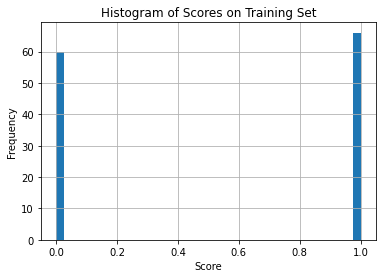

In [24]:
labeled_pairs_df["score"].hist(bins = 40)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Histogram of Scores on Training Set")
plt.show()

In [25]:
y_true = labeled_pairs_df["label"]
y_pred = labeled_pairs_df["predicted label"]
print("Confusion Matrix\n{}".format(confusion_matrix(y_true, y_pred, labels = ["match", "distinct"])))
print("Accuracy Score {:.1f}%".format(accuracy_score(y_true, y_pred)*100))

Confusion Matrix
[[66  0]
 [ 0 60]]
Accuracy Score 100.0%
